# Variational Inference

## Abstract

I summarize variational inference as an alternative to Monte Carlo sampling in making a Bayesian inference, and perform variational inference for a simple linear model.

## Variational Inference

At the heart of Bayesian inference is the inference of posterior probability density distributions. Given some observations $x$ which is related to a set of latent variables $z$ that we would like to learn about, making an inference is to approximate the distribution

$$ p(z,x) = p(z) p(x|z) $$

Here, $p(z)$ describes the prior belief about the latent variables, and $p(x|z)$ is the likelihood.

One way to make the approximation is to Monte Carlo sample from the distribution $p(z, x)$. In MCMC, we draw samples from the chain whose stationary distribution is the posterior $p(z|x)$, and approximate the posterior PDF with this sample. This has been the most popular method in Bayesian inference, and there are many algorythms such as Metropolis-Hastings, Gibbs, and Hamiltonian Monte Carlo developed.

On the other hand, in variational inference, we approximate the posterior pdf with a flexible family of parametrized PDFs, $q(z)$, and seek to find the values of the parameters which minimizes certain metric that measures the deviation of the proposed PDF from the true poster PDF.
Thus, the problem of posterior inference now becomes an optimization rather than sampling problem. A choice for the metric is the Kullback-Leibler (KL) divergence.

$$q^*(z) = argmin\,KL(q(z) || p(z|x)) $$

The key is to choose $q(z)$ so that it is flexible enough yet simple for fast optimization.


Variational inference and MCMC are two different approches to the same problem, inference of $p(z,x)$. They have complimentary advantages and disadvantages that make one better suited for some problems than the other. MCMC methods are more general and flexible, and guaranteed to converge to $p(z,x)$ but can be computationally expensive.
Variational inference only finds the closest of the proposed family of PDFs without any guarantee of convergence, but can take advantage of fast optimization algorythms, and hence is better suited for e.g., exploring multiple models for a large data set.

## Application to a linear model

I compare the result of variational inference using KL divergence with MC sampling for a very simple model $y = mx+b$. First, I generate some mock heteroscedastic data ${x_i, y_i}$ described by a the model with Gaussian noise $y_{\mathrm{err},i}$

In [1]:
%matplotlib inline
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Normal, Empirical

plt.style.use('fivethirtyeight')

In [2]:
N = 100
m_true = 1.53
b_true = 2.34

x = np.random.uniform(-5, 5, N)
x.sort()

y = m_true*x + b_true
y_err = np.random.uniform(0.1, 1, size=N)
y_obs = np.random.normal(y, y_err)

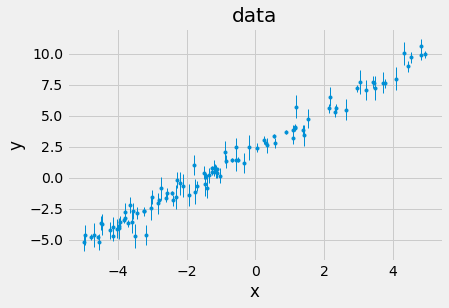

In [3]:
plt.errorbar(x, y_obs, y_err, fmt='.', elinewidth=1);
plt.xlabel('x');
plt.ylabel('y');
plt.title('data')

I use [edwardlib](http://edwardlib.org/) which has unified interface for inference using either MCMC or variational inference.

In [4]:
# Define the model
X = tf.placeholder(tf.float32, [N,])   # placeholder for data
sigma = tf.placeholder(tf.float32, [N,])   # placeholder for covariance
# The following specifies that the scalar parameters w, b (slope, intercept)
# are drawn from a prior N(1,1).
w = Normal(mu=tf.zeros(1), sigma=tf.ones(1))
b = Normal(mu=tf.zeros(1), sigma=tf.ones(1))
y = Normal(mu=X*w + b, sigma=sigma)

## Inference using MCMC

First, I use Hamiltonian MC to draw 1000 samples burning in the first 50.

In [64]:
n_sample = 1050
qw = Empirical(params=tf.Variable(tf.ones([n_sample,1])*0.5))
qb = Empirical(params=tf.Variable(tf.ones([n_sample,1])))

inference = ed.HMC({w:qw, b:qb}, data={X:x, y:y_obs, sigma:y_err})
inference.run(step_size=0.01)


Iteration    1 [  0%]: Acceptance Rate = nan
Iteration  105 [ 10%]: Acceptance Rate = 0.91
Iteration  210 [ 20%]: Acceptance Rate = 0.93
Iteration  315 [ 30%]: Acceptance Rate = 0.94
Iteration  420 [ 40%]: Acceptance Rate = 0.94
Iteration  525 [ 50%]: Acceptance Rate = 0.93
Iteration  630 [ 60%]: Acceptance Rate = 0.93
Iteration  735 [ 70%]: Acceptance Rate = 0.94
Iteration  840 [ 80%]: Acceptance Rate = 0.94
Iteration  945 [ 90%]: Acceptance Rate = 0.94
Iteration 1050 [100%]: Acceptance Rate = 0.94


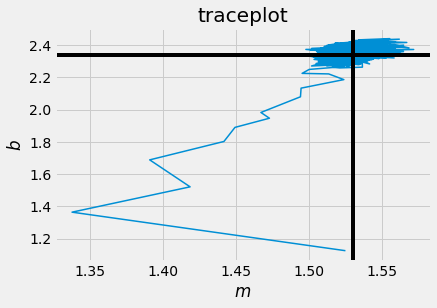

In [65]:
plt.plot(qw.params.eval().ravel(), qb.params.eval().ravel(), lw=1.5)
plt.xlabel('$m$')
plt.ylabel('$b$')
plt.axvline(m_true, c='k');
plt.axhline(b_true, c='k');
plt.title('traceplot');

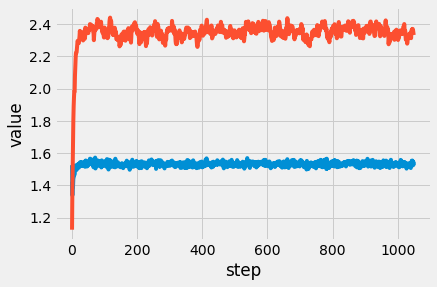

In [66]:
plt.plot(qw.params.eval(),);
plt.plot(qb.params.eval(),);
plt.xlabel('step');
plt.ylabel('value');

In [67]:
wpost = qw.params.eval().ravel()[50:]
bpost = qb.params.eval().ravel()[50:]

In [68]:
print('parameter using HMC')
print('w = {:.3f} +- {:.3f}'.format(wpost.mean(),wpost.std()))
print('b = {:.3f} +- {:.3f}'.format(bpost.mean(),bpost.std()))

parameter using HMC
w = 1.532 +- 0.013
b = 2.353 +- 0.033


## Inference using variational inference

I now do the same inference, only this time I use variational inference using KL divergence.
I use Gaussians as my proposal family of PDFs, and seek to find the location and scale for $m$ and $b$.

In [81]:
qw = Normal(mu=tf.Variable(tf.random_normal([1])),
            sigma=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qb = Normal(mu=tf.Variable(tf.random_normal([1])),
            sigma=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [82]:
inference = ed.KLqp({w: qw, b: qb}, data={X: x, y: y_obs, sigma:y_err})
inference.run(n_samples=5, n_iter=1000)

Iteration    1 [  0%]: Loss = 7432.327
Iteration  100 [ 10%]: Loss = 78.920
Iteration  200 [ 20%]: Loss = 80.447
Iteration  300 [ 30%]: Loss = 71.501
Iteration  400 [ 40%]: Loss = 75.248
Iteration  500 [ 50%]: Loss = 70.671
Iteration  600 [ 60%]: Loss = 72.647
Iteration  700 [ 70%]: Loss = 73.779
Iteration  800 [ 80%]: Loss = 72.208
Iteration  900 [ 90%]: Loss = 71.597
Iteration 1000 [100%]: Loss = 71.040


In [83]:
print('parameter using VI')
print('w = {:.3f} +- {:.3f}'.format(qw.mean().eval()[0], qw.std().eval()[0]))
print('b = {:.3f} +- {:.3f}'.format(qb.mean().eval()[0], qb.std().eval()[0]))


parameter using VI
w = 1.530 +- 0.014
b = 2.356 +- 0.033


In [84]:
wpost2 = qw.sample(1000).eval().ravel()
bpost2 = qb.sample(1000).eval().ravel()

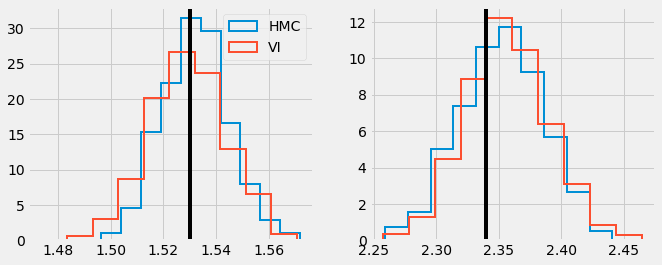

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].hist(wpost, normed=True, histtype='step', lw=2, label='HMC');
ax[0].hist(wpost2, normed=True, histtype='step', lw=2, label='VI');
ax[0].legend();
ax[0].axvline(m_true, c='k');

ax[1].hist(bpost, normed=True, histtype='step', lw=2);
ax[1].hist(bpost2, normed=True, histtype='step', lw=2);
ax[1].axvline(b_true, c='k');

In [57]:
def visualise(w_samples, b_samples):
    n_samples = len(w_samples)
    inputs = np.linspace(-8, 8, num=400, dtype=np.float32)
    for ns in range(n_samples):
        output = inputs * w_samples[ns] + b_samples[ns]
        plt.plot(inputs, output, 'k-', alpha=.3)

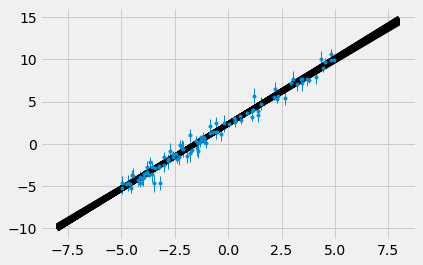

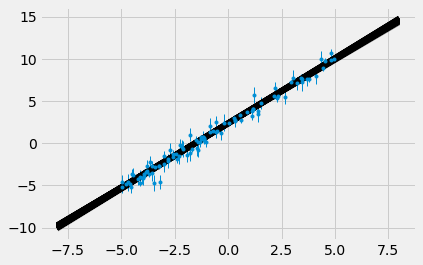

In [58]:
plt.figure()
plt.errorbar(x, y_obs, y_err, fmt='.', lw=1);
visualise(wpost, bpost)

plt.figure()
plt.errorbar(x, y_obs, y_err, fmt='.', lw=1);
visualise(wpost2, bpost2)

The true parameters are recovered well by both MCMC and variational inference methods. While it makes little difference which method I use for this simple model, this method may be useful for testing different models for data of size $> 1$ million.

## References

- [Variational Inference: A Review for Statisticians](https://arxiv.org/abs/1601.00670)
- [Edwardlib](http://edwardlib.org/)